Primera parte del taller:

1. Ingestar las fuentes de información al HDFS.
2. Crear tablas hive las cuales hagan referencia a las entidades ingestadas.
3. Crear un archivo en jupyter(Spark) el cual lean los objetos creados en el punto2, luego proceder a unir los dos objetos por el numero_documento y generen un nuevo dataframe con esta unión(con todas las columnas), revisar la nueva entidad(columnas, tipos de dato, etc.), y guardar el dataframe en el hdfs de procesamiento.
4. Utilice la columna FlagSample para dividir la muestra en entrenamiento y prueba.
5. Cree un modelo randomforest con el nuevo dataframe( solo utilice las variables mencionadas en la diapositiva 6), pruebe elmodelo y guarde el modelo.

/user/yarasca_bedon/data_in/dataentry/credito

/user/yarasca_bedon/data_in/dbbanco/dbanco/base_clientes

In [1]:
import findspark
findspark.init('/opt/cloudera/parcels/SPARK2-2.3.0.cloudera3-1.cdh5.13.3.p0.458809/lib/spark2')

In [2]:
import pyspark
from pyspark.sql import SparkSession

In [3]:
#spark = SparkSession.builder.appName('SESSION_M').getOrCreate()
spark = SparkSession.builder.appName('martin_y').getOrCreate()


In [4]:
spark.sql("show databases").show()

+------------+
|databaseName|
+------------+
|       bd_jr|
|bruno_martin|
|  brunobedon|
|     cahuana|
| carloslopez|
|      datag3|
|     default|
|    dnarvaez|
|     gabarca|
|       jonap|
| joserosadio|
|       jvega|
|    mmedinac|
|  msarachaga|
|    myarasca|
|    tableyap|
|  temporales|
|  villacorta|
+------------+



In [5]:
credito = spark.sql('SELECT * FROM bruno_martin.chilean_credit')
clientes = spark.sql('SELECT * FROM bruno_martin.clientes_banco')

In [6]:
print( type(credito) )
print( type(clientes) )

<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>


In [7]:
print( credito.count() ) 
print( clientes.count() ) 

7703
50000


In [8]:
df = credito.withColumnRenamed("customerid", "numerodocumento")

df = df.join(clientes, on="numerodocumento", how="inner")

print( credito.count() )
print( clientes.count() )
print( df.count() )

7703
50000
15404


In [9]:
df.show()

+---------------+---+--------+----------+--------+-----------------+------+----------+----------+----------+---------------+----+----+------------+---------+--------------------+------------------+-----------+
|numerodocumento|tob|   bal01|maxdqbin01|mtgbal01|nonbanktradesdq01|flaggb|flagsample|    APEPAT|    APEMAT|        NOMBRES|EDAD|SEXO|DEPARTAMENTO|PROVINCIA|            DISTRITO|ESTADOCIVILTITULAR|IncomeLevel|
+---------------+---+--------+----------+--------+-----------------+------+----------+----------+----------+---------------+----+----+------------+---------+--------------------+------------------+-----------+
|       41011903| 43|  613.21|         0|       0|                0|     1|         1|      DIAZ|   CORDOVA|  LORENA ROXANA|  33|   F|        LIMA|     LIMA|   MAGDALENA DEL MAR|                CS|          2|
|       41011903| 43|  613.21|         0|       0|                0|     1|         1|      DIAZ|   CORDOVA|  LORENA ROXANA|  33|   F|        LIMA|     LIMA|   

In [10]:
print( df.columns ) ; print("\n");
print( df.dtypes ) 

['numerodocumento', 'tob', 'bal01', 'maxdqbin01', 'mtgbal01', 'nonbanktradesdq01', 'flaggb', 'flagsample', 'APEPAT', 'APEMAT', 'NOMBRES', 'EDAD', 'SEXO', 'DEPARTAMENTO', 'PROVINCIA', 'DISTRITO', 'ESTADOCIVILTITULAR', 'IncomeLevel']


[('numerodocumento', 'string'), ('tob', 'int'), ('bal01', 'float'), ('maxdqbin01', 'int'), ('mtgbal01', 'int'), ('nonbanktradesdq01', 'int'), ('flaggb', 'int'), ('flagsample', 'int'), ('APEPAT', 'string'), ('APEMAT', 'string'), ('NOMBRES', 'string'), ('EDAD', 'int'), ('SEXO', 'string'), ('DEPARTAMENTO', 'string'), ('PROVINCIA', 'string'), ('DISTRITO', 'string'), ('ESTADOCIVILTITULAR', 'string'), ('IncomeLevel', 'int')]


In [12]:
df.write.saveAsTable('credito_clientes')

In [13]:
spark.sql("use bruno_martin").show();
spark.sql("show tables").show()

++
||
++
++

+------------+----------------+-----------+
|    database|       tableName|isTemporary|
+------------+----------------+-----------+
|bruno_martin|  chilean_credit|      false|
|bruno_martin|  clientes_banco|      false|
|bruno_martin|credito_clientes|      false|
+------------+----------------+-----------+



In [14]:
spark.sql("select * from bruno_martin.credito_clientes limit 3").show()

+---------------+---+--------+----------+--------+-----------------+------+----------+-------+----------------+----------------+----+----+------------+---------+----------+------------------+-----------+
|numerodocumento|tob|   bal01|maxdqbin01|mtgbal01|nonbanktradesdq01|flaggb|flagsample| apepat|          apemat|         nombres|edad|sexo|departamento|provincia|  distrito|estadociviltitular|incomelevel|
+---------------+---+--------+----------+--------+-----------------+------+----------+-------+----------------+----------------+----+----+------------+---------+----------+------------------+-----------+
|       41004726|  5|10179.99|         0|       0|                0|     0|         1| ARAUJO|MOLINA DE QUISPE|    LIDIA TERESA|  34|   F|        LIMA|     LIMA|CARABAYLLO|                CS|          0|
|       41004726|  5|10179.99|         0|       0|                0|     0|         1| ARAUJO|MOLINA DE QUISPE|    LIDIA TERESA|  34|   F|        LIMA|     LIMA|CARABAYLLO|            

In [15]:
spark.sql("select flagsample, count(*) from credito_clientes group by flagsample").show()

+----------+--------+
|flagsample|count(1)|
+----------+--------+
|         1|   11600|
|         0|    3804|
+----------+--------+



In [16]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pandas.tools.plotting import scatter_matrix
%matplotlib inline 
import matplotlib.pyplot as plt, numpy as np

In [17]:
training_data = spark.sql("select numerodocumento, tob, incomelevel, bal01, maxdqbin01, mtgbal01, nonbanktradesdq01, flaggb, flagsample   from credito_clientes where flagsample=1")
test_data = spark.sql("select numerodocumento, tob, incomelevel, bal01, maxdqbin01, mtgbal01, nonbanktradesdq01, flaggb, flagsample   from credito_clientes where flagsample=0")
training_data.show()

+---------------+---+-----------+-------+----------+--------+-----------------+------+----------+
|numerodocumento|tob|incomelevel|  bal01|maxdqbin01|mtgbal01|nonbanktradesdq01|flaggb|flagsample|
+---------------+---+-----------+-------+----------+--------+-----------------+------+----------+
|       41040309| 76|          1| 107.48|         0|       0|                0|     1|         1|
|       41040309| 76|          1| 107.48|         0|       0|                0|     1|         1|
|       41051503|  4|          0|  78.61|         0|       0|                0|     0|         1|
|       41051503|  4|          0|  78.61|         0|       0|                0|     0|         1|
|       41073444|  0|          1|   3.17|         0|       0|                0|     1|         1|
|       41073444|  0|          1|   3.17|         0|       0|                0|     1|         1|
|       41113246|  7|          0| 445.21|         0|       0|                1|     1|         1|
|       41113246|  7

In [18]:
assembler = VectorAssembler(inputCols=["tob", "incomelevel", "bal01", "maxdqbin01", "mtgbal01", "nonbanktradesdq01"], outputCol="features")
assem_data = assembler.transform(training_data)

assembler_test = VectorAssembler(inputCols=["tob", "incomelevel", "bal01", "maxdqbin01", "mtgbal01", "nonbanktradesdq01"], outputCol="features")
assem_data_test = assembler_test.transform(test_data)

In [19]:
train_scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
train_scaler_model = train_scaler.fit(assem_data)
scaled_data_train = train_scaler_model.transform(assem_data)

test_scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
test_scaler_model = test_scaler.fit(assem_data_test)
scaled_data_test = test_scaler_model.transform(assem_data_test)

In [20]:
rf = RandomForestClassifier(labelCol="flaggb", featuresCol="scaled_features")
rfModel = rf.fit(scaled_data_train)

In [21]:
# Score test Data
predictions = rfModel.transform(scaled_data_test)
predictions.show()

+---------------+---+-----------+--------+----------+--------+-----------------+------+----------+--------------------+--------------------+--------------------+--------------------+----------+
|numerodocumento|tob|incomelevel|   bal01|maxdqbin01|mtgbal01|nonbanktradesdq01|flaggb|flagsample|            features|     scaled_features|       rawPrediction|         probability|prediction|
+---------------+---+-----------+--------+----------+--------+-----------------+------+----------+--------------------+--------------------+--------------------+--------------------+----------+
|       41165325| 10|          0| 1151.95|         1|       0|                1|     0|         0|[10.0,0.0,1151.94...|[-0.7423597740252...|[12.1548899012001...|[0.60774449506000...|       0.0|
|       41165325| 10|          0| 1151.95|         1|       0|                1|     0|         0|[10.0,0.0,1151.94...|[-0.7423597740252...|[12.1548899012001...|[0.60774449506000...|       0.0|
|       41344521|182|         

In [22]:
spark.sql("show tables").show()

+------------+----------------+-----------+
|    database|       tableName|isTemporary|
+------------+----------------+-----------+
|bruno_martin|  chilean_credit|      false|
|bruno_martin|  clientes_banco|      false|
|bruno_martin|credito_clientes|      false|
+------------+----------------+-----------+



In [23]:
#codigo para obtener la matriz de confusión
predictions.createOrReplaceTempView("rf_model_bruno_martin")

In [24]:
spark.sql("show tables").show()

+------------+--------------------+-----------+
|    database|           tableName|isTemporary|
+------------+--------------------+-----------+
|bruno_martin|      chilean_credit|      false|
|bruno_martin|      clientes_banco|      false|
|bruno_martin|    credito_clientes|      false|
|            |rf_model_bruno_ma...|       true|
+------------+--------------------+-----------+



In [25]:
spark.sql("""
            select flaggb as real, prediction, count(1) as cantidad
              from rf_model_bruno_martin
              group by flaggb, prediction
              order by 1, 2 asc
          """).show()

+----+----------+--------+
|real|prediction|cantidad|
+----+----------+--------+
|   0|       0.0|     650|
|   0|       1.0|     318|
|   1|       0.0|     370|
|   1|       1.0|    2466|
+----+----------+--------+



In [26]:
predictions.columns

['numerodocumento',
 'tob',
 'incomelevel',
 'bal01',
 'maxdqbin01',
 'mtgbal01',
 'nonbanktradesdq01',
 'flaggb',
 'flagsample',
 'features',
 'scaled_features',
 'rawPrediction',
 'probability',
 'prediction']

In [27]:
predictions.select("numerodocumento", "flaggb", "probability", "prediction").show()

+---------------+------+--------------------+----------+
|numerodocumento|flaggb|         probability|prediction|
+---------------+------+--------------------+----------+
|       41165325|     0|[0.60774449506000...|       0.0|
|       41165325|     0|[0.60774449506000...|       0.0|
|       41344521|     1|[0.06800900759765...|       1.0|
|       41344521|     1|[0.06800900759765...|       1.0|
|       41444452|     1|[0.09741745124164...|       1.0|
|       41444452|     1|[0.09741745124164...|       1.0|
|       41477822|     0|[0.10221583869741...|       1.0|
|       41477822|     0|[0.10221583869741...|       1.0|
|       41515312|     1|[0.07306020436279...|       1.0|
|       41515312|     1|[0.07306020436279...|       1.0|
|       41582237|     1|[0.04582794904030...|       1.0|
|       41582237|     1|[0.04582794904030...|       1.0|
|       41591403|     1|[0.11920994188682...|       1.0|
|       41591403|     1|[0.11920994188682...|       1.0|
|       41813872|     0|[0.8603

In [58]:
from pyspark.sql.functions import  expr
prediction_2 = predictions.select(expr("*"),expr("cast(probability as string)  as probability_2"))

prediction_2 = prediction_2.select("numerodocumento", "flaggb", "prediction", expr("substr(probability_2,1,instr(probability_2,',')) as p0"),
                       expr("substr(probability_2,instr(probability_2,',')+1,length(probability_2)) as p1"),
                      )
prediction_2.show()

+---------------+------+----------+--------------------+--------------------+
|numerodocumento|flaggb|prediction|                  p0|                  p1|
+---------------+------+----------+--------------------+--------------------+
|       41165325|     0|       0.0| [0.607744495060009,|0.39225550493999095]|
|       41165325|     0|       0.0| [0.607744495060009,|0.39225550493999095]|
|       41344521|     1|       1.0|[0.06800900759765...| 0.9319909924023495]|
|       41344521|     1|       1.0|[0.06800900759765...| 0.9319909924023495]|
|       41444452|     1|       1.0|[0.0974174512416445,| 0.9025825487583555]|
|       41444452|     1|       1.0|[0.0974174512416445,| 0.9025825487583555]|
|       41477822|     0|       1.0|[0.10221583869741...|  0.897784161302582]|
|       41477822|     0|       1.0|[0.10221583869741...|  0.897784161302582]|
|       41515312|     1|       1.0|[0.07306020436279...| 0.9269397956372024]|
|       41515312|     1|       1.0|[0.07306020436279...| 0.92693

In [63]:
from pyspark.sql.functions import * 
#prediction_2 = prediction_2.withColumn('p0', regexp_replace('p0', '[', '0'))
#prediction_2 = prediction_2.withColumn('p0', regexp_replace('p0', '[', ''))
prediction_2 = prediction_2.select('numerodocumento', "flaggb","prediction",expr("replace(replace(p0,'[',''),',','') as p0"),expr("replace(p1,']','') as p1"))

In [64]:
prediction_2.show()

+---------------+------+----------+-------------------+-------------------+
|numerodocumento|flaggb|prediction|                 p0|                 p1|
+---------------+------+----------+-------------------+-------------------+
|       41165325|     0|       0.0|  0.607744495060009|0.39225550493999095|
|       41165325|     0|       0.0|  0.607744495060009|0.39225550493999095|
|       41344521|     1|       1.0|0.06800900759765044| 0.9319909924023495|
|       41344521|     1|       1.0|0.06800900759765044| 0.9319909924023495|
|       41444452|     1|       1.0| 0.0974174512416445| 0.9025825487583555|
|       41444452|     1|       1.0| 0.0974174512416445| 0.9025825487583555|
|       41477822|     0|       1.0|0.10221583869741795|  0.897784161302582|
|       41477822|     0|       1.0|0.10221583869741795|  0.897784161302582|
|       41515312|     1|       1.0|0.07306020436279752| 0.9269397956372024|
|       41515312|     1|       1.0|0.07306020436279752| 0.9269397956372024|
|       4158

In [38]:
prediction_2.write.saveAsTable('prediction_p0_p1')
spark.sql("show tables").show()

+------------+--------------------+-----------+
|    database|           tableName|isTemporary|
+------------+--------------------+-----------+
|bruno_martin|      chilean_credit|      false|
|bruno_martin|      clientes_banco|      false|
|bruno_martin|    credito_clientes|      false|
|bruno_martin|credito_clientes_...|      false|
|bruno_martin|    prediction_p0_p1|      false|
|            |rf_model_bruno_ma...|       true|
+------------+--------------------+-----------+



In [39]:
import sys
import os
sys.path.append(os.path.abspath("/home/jupyter/funciones"))

In [65]:
df_pandas = prediction_2.toPandas()

In [41]:
import pyspark_ml_util as miutil

In [66]:
df_pandas.head()

,numerodocumento,flaggb,prediction,p0,p1
0,41165325,0,0.0,0.607744495060009,0.39225550493999095
1,41165325,0,0.0,0.607744495060009,0.39225550493999095
2,41344521,1,1.0,0.06800900759765044,0.9319909924023495
3,41344521,1,1.0,0.06800900759765044,0.9319909924023495
4,41444452,1,1.0,0.0974174512416445,0.9025825487583555


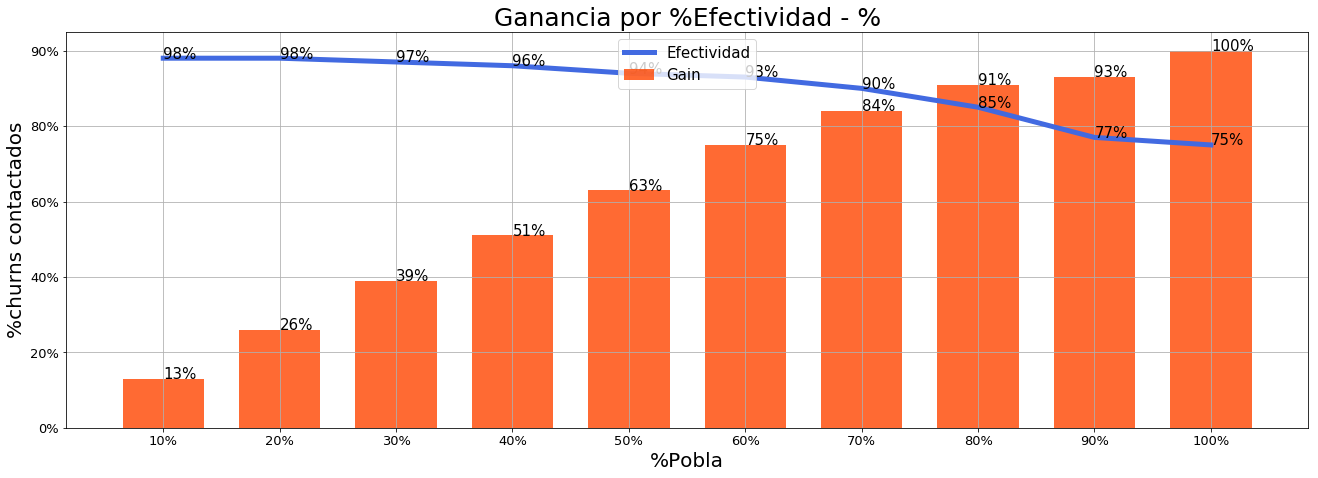

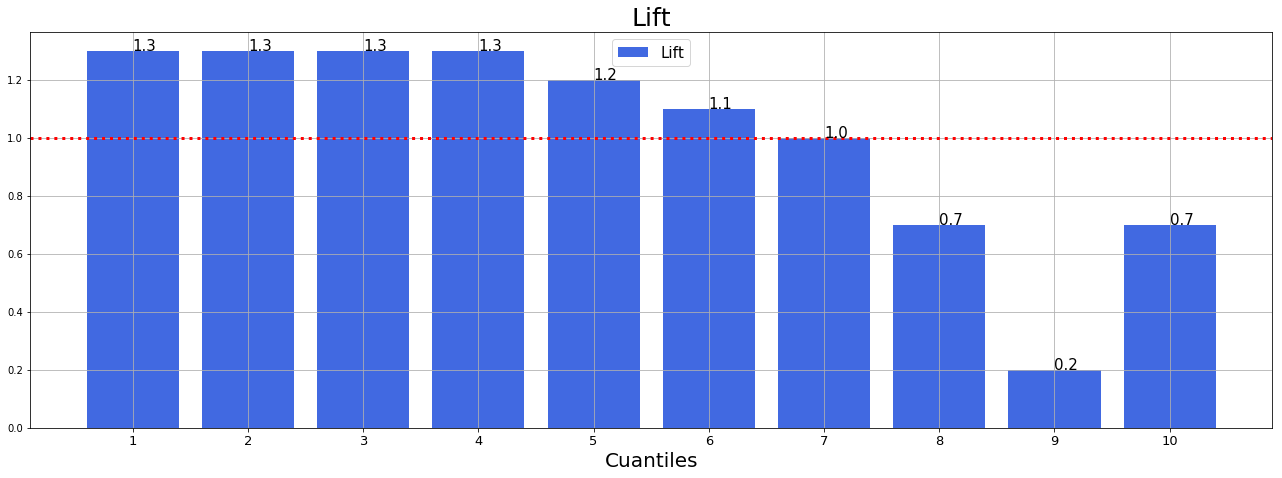

In [67]:
miutil.reporte_ganancia_lift(df_pandas['flaggb'],df_pandas['p1'],10)

In [68]:
miutil.confusion_matrix(df_pandas['flaggb'], df_pandas['prediction'])

array([[ 650,  318],
       [ 370, 2466]])

In [69]:
df_pandas.head()

,numerodocumento,flaggb,prediction,p0,p1
0,41165325,0,0.0,0.607744495060009,0.39225550493999095
1,41165325,0,0.0,0.607744495060009,0.39225550493999095
2,41344521,1,1.0,0.06800900759765044,0.9319909924023495
3,41344521,1,1.0,0.06800900759765044,0.9319909924023495
4,41444452,1,1.0,0.0974174512416445,0.9025825487583555


In [52]:
df_pandas['p1'].head()

0    0.39225550493999095]
1    0.39225550493999095]
2     0.9319909924023495]
3     0.9319909924023495]
4     0.9025825487583555]
Name: p1, dtype: object

In [ ]:
df_pandas['p1'] = 

In [49]:
df_pandas['p1'].head()

0    0.39225550493999095]
1    0.39225550493999095]
2     0.9319909924023495]
3     0.9319909924023495]
4     0.9025825487583555]
Name: p1, dtype: object

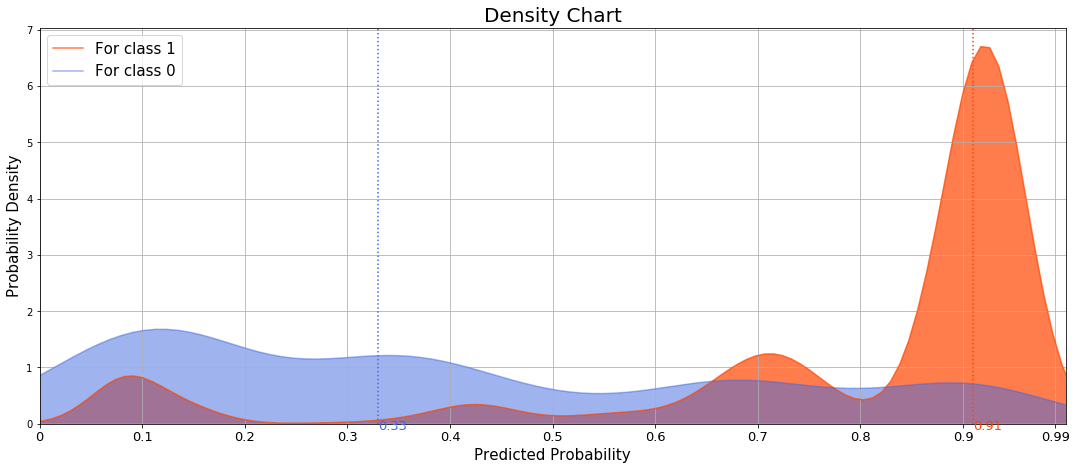

In [70]:
miutil.density_chart(df_pandas['flaggb'], df_pandas['p1'])

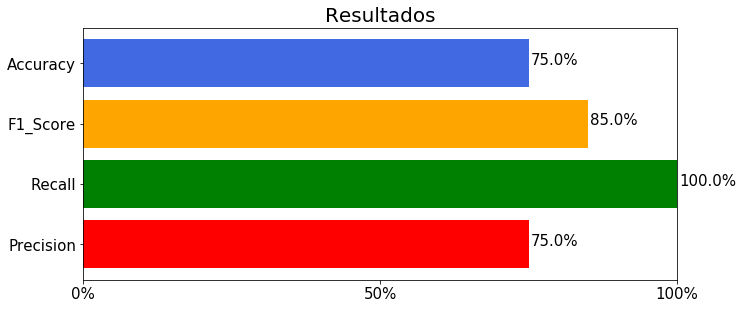

In [72]:
miutil.indicadores_modelos(df_pandas['flaggb'], df_pandas['p1'])